In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection\\Pretrained Models\\ResNet50V2'

In [3]:
os.chdir("../")
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection'

In [5]:
# Configuration
BASE_DIR = "artifacts/data_ingestion/Combined_Training_Data"
MODEL_PATH = "Pretrained Models/ResNet50V2/resnet50v2_kidney_stone_model_trained.h5"  # Path to the trained model
IMAGE_SIZE = (299, 299)  # Make sure this matches the model's input size
BATCH_SIZE = 32

# Create directory for evaluation results
RESULTS_DIR = "Pretrained Models/ResNet50V2/evaluation_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [6]:
# Load the trained model
model = load_model(MODEL_PATH)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 305, 305, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [7]:
# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# We'll use the validation split as our test set for evaluation
test_generator = test_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important: don't shuffle for evaluation
)

# Print class mapping
print(f"Class indices: {test_generator.class_indices}")

Found 38821 images belonging to 2 classes.
Class indices: {'Non-Stone': 0, 'Stone': 1}


In [8]:
# Evaluate the model
evaluation = model.evaluate(test_generator)
metrics_names = model.metrics_names

# Print evaluation results
print("\nModel Evaluation Results:")
for name, value in zip(metrics_names, evaluation):
    print(f"{name}: {value:.4f}")

1214/1214 [==============================] - 2163s 2s/step - loss: 0.5376 - accuracy: 0.7214 - auc: 0.8176 - precision: 0.7810 - recall: 0.5635

Model Evaluation Results:
loss: 0.5376
accuracy: 0.7214
auc: 0.8176
precision: 0.7810
recall: 0.5635


In [9]:
# Get predictions
test_generator.reset()
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Make sure predictions and true labels have the same length
y_pred = y_pred[:len(y_true)]
y_pred_prob = y_pred_prob[:len(y_true)]

1214/1214 [==============================] - 1935s 2s/step


In [10]:
# Generate classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)

# Save the report to a file
with open(f"{RESULTS_DIR}/classification_report.txt", "w") as f:
    f.write(report)


Classification Report:
              precision    recall  f1-score   support

   Non-Stone       0.69      0.86      0.77     20627
       Stone       0.78      0.56      0.65     18194

    accuracy                           0.72     38821
   macro avg       0.74      0.71      0.71     38821
weighted avg       0.73      0.72      0.71     38821



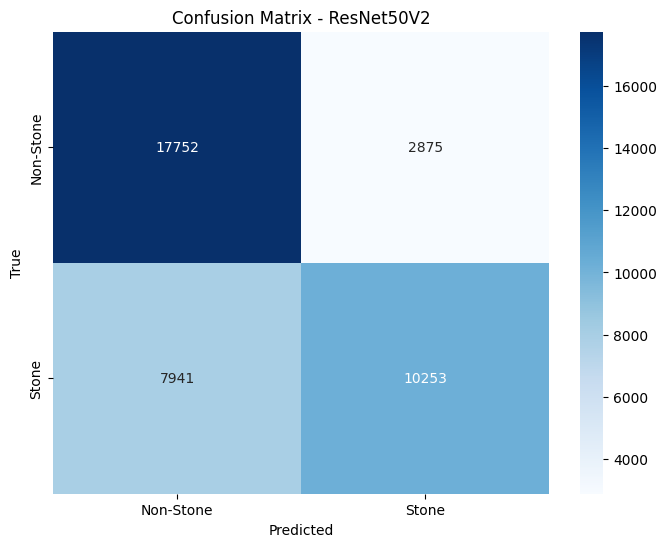

In [11]:
# Generate and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet50V2')
plt.savefig(f"{RESULTS_DIR}/confusion_matrix.png", bbox_inches='tight')
plt.show()

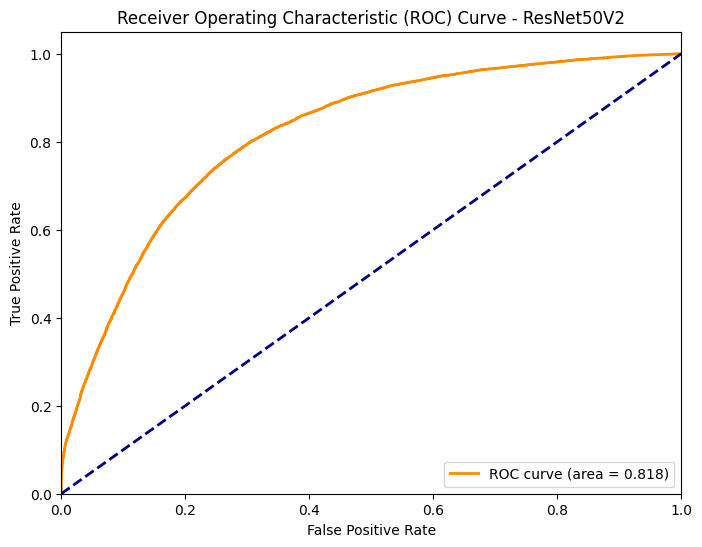

In [12]:
# Generate and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - ResNet50V2')
plt.legend(loc="lower right")
plt.savefig(f"{RESULTS_DIR}/roc_curve.png", bbox_inches='tight')
plt.show()

In [13]:
# Calculate and print additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Save metrics to a file
with open(f"{RESULTS_DIR}/metrics_summary.txt", "w") as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1 Score: {f1:.4f}\n")
    f.write(f"ROC AUC: {roc_auc:.4f}\n")

print(f"\nMetrics saved to {RESULTS_DIR}/metrics_summary.txt")


Additional Metrics:
Accuracy: 0.7214
Precision: 0.7810
Recall: 0.5635
F1 Score: 0.6547
ROC AUC: 0.8176

Metrics saved to Pretrained Models/ResNet50V2/evaluation_results/metrics_summary.txt


1/1 [==============================] - 3s 3s/step


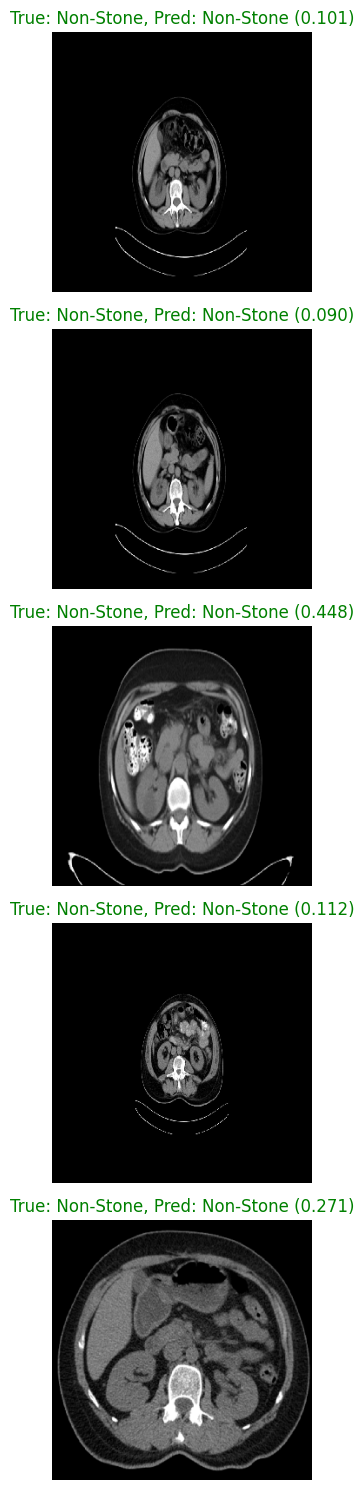

In [14]:
# Visualize some example predictions
def plot_sample_predictions(generator, model, num_samples=5):
    generator.reset()
    
    # Get a batch of images and their true labels
    batch_x, batch_y = next(generator)
    
    # Make predictions
    preds = model.predict(batch_x)
    
    # Plot the images with their predictions
    plt.figure(figsize=(15, 3*num_samples))
    for i in range(min(num_samples, len(batch_x))):
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(batch_x[i])
        true_label = "Stone" if batch_y[i] == 1 else "Non-Stone"
        pred_label = "Stone" if preds[i][0] > 0.5 else "Non-Stone"
        pred_prob = preds[i][0]
        title = f"True: {true_label}, Pred: {pred_label} ({pred_prob:.3f})"
        plt.title(title, color='green' if true_label == pred_label else 'red')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/sample_predictions.png", bbox_inches='tight')
    plt.show()

# Plot some sample predictions
plot_sample_predictions(test_generator, model, num_samples=5)